In [ ]:
from math import sqrt 
import datetime as dt
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import time
import json
import tensorflow as tf

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, accuracy_score
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout
from keras import backend as K
from imblearn.combine import SMOTEENN

%matplotlib inline

#Funciones

In [ ]:
def helada(row):
  if row['Y'] <= 0:
    return 0
  else: 
    return 1 

#Parámetros

In [ ]:
look_back=18
col=['LowTemp','OutHum']
colnames= []

In [ ]:
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred )) 
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Preprocesamiento

In [ ]:
for i in range(look_back): 
  for s in col:
    colnames.append(s+str(i+1))

cantCaract= len(colnames)

colnames.append("Y")
colnames_remuestreo= colnames.copy()
colnames.append("DateTime")

In [ ]:
df_inta = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/datosINTA_TempHumRocioVientoRadBarHora_conVentana3hs_3hshorizonte.csv', usecols=colnames,low_memory=False)
df_inta['DateTime'] = pd.to_datetime(df_inta['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_test= df_inta.sort_values(by='DateTime')

In [ ]:
df_sftrain= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos2/Temp_Hum_Smoteen_vent3_hor3_train.csv', usecols=colnames_remuestreo,low_memory=False)
df_sfval= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos2/Temp_Hum_Smoteen_vent3_hor3_val.csv', usecols=colnames_remuestreo,low_memory=False)

In [ ]:
col_num= colnames[:cantCaract+1]
for c in col_num:
  df_inta[c].mask(df_inta[c] == '---',0,inplace=True)
  df_inta[c]= pd.to_numeric(df_inta[c])

In [ ]:
xtrain= df_sftrain.iloc[:,0:cantCaract]
ytrain= df_sftrain.loc[:,'Y']
xval= df_sfval.iloc[:,0:cantCaract]
yval= df_sfval.loc[:,'Y']
xtest= df_test.iloc[:,0:cantCaract]
ytest= df_test.loc[:,'Y']

In [ ]:
df_sftrain

,LowTemp18,OutHum18,LowTemp17,OutHum17,LowTemp16,OutHum16,LowTemp15,OutHum15,LowTemp14,OutHum14,...,OutHum5,LowTemp4,OutHum4,LowTemp3,OutHum3,LowTemp2,OutHum2,LowTemp1,OutHum1,Y
0,15.0,47,14.0,49,13.5,56,12.4,61,11.2,63,...,81,1.9,81,1.4,81,0.9,82,0.6,83,-1.9
1,14.0,49,13.5,56,12.4,61,11.2,63,9.3,66,...,81,1.4,81,0.9,82,0.6,83,0.2,84,-1.8
2,13.5,56,12.4,61,11.2,63,9.3,66,7.6,70,...,81,0.9,82,0.6,83,0.2,84,-0.1,84,-1.9
3,12.4,61,11.2,63,9.3,66,7.6,70,6.3,73,...,82,0.6,83,0.2,84,-0.1,84,-0.2,84,-2.0
4,9.3,66,7.6,70,6.3,73,5.1,75,4.1,77,...,84,-0.1,84,-0.2,84,-0.5,85,-0.7,85,-2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65521,9.8,42,9.7,43,9.3,45,9.1,46,8.8,47,...,60,6.1,62,6.0,64,5.9,64,5.7,65,4.4
65522,9.7,43,9.3,45,9.1,46,8.8,47,8.5,48,...,62,6.0,64,5.9,64,5.7,65,5.3,66,4.1
65523,9.3,45,9.1,46,8.8,47,8.5,48,8.2,51,...,64,5.9,64,5.7,65,5.3,66,5.1,68,3.9
65524,9.1,46,8.8,47,8.5,48,8.2,51,7.9,52,...,64,5.7,65,5.3,66,5.1,68,4.9,69,3.9


#** estandariza features**

In [ ]:
scalerX = StandardScaler()
scalerY = StandardScaler()

dataX= pd.concat([xtrain, xval, xtest], axis=0)
dataY= pd.concat([ytrain, yval, ytest], axis=0)

dataX= dataX.to_numpy()
print('----------X---------')
print(scalerX.fit(dataX.astype('float32')))
print('-------------------')
print(scalerX.mean_)
print(len(scalerX.mean_))

dataY= dataY.to_numpy().reshape(-1,1)
print('----------Y---------')
print(scalerY.fit(dataY.astype('float32')))
print('-------------------')
print(scalerY.mean_)

----------X---------
StandardScaler()
-------------------
[ 6.55891374 67.83598827  6.3546328  68.38912753  6.1535052  68.93081766
  5.95771405 69.45291314  5.76908689 69.95062247  5.58889069 70.42677012
  5.41891561 70.87718664  5.26009425 71.29787914  5.11263221 71.6917225
  4.97586378 72.05670766  4.8479521  72.39712175  4.72760657 72.71486454
  4.61405883 73.01782097  4.50593719 73.30571364  4.40176319 73.57968578
  4.30086512 73.84609242  4.20177916 74.10844731  4.10493172 74.36399324]
36
----------Y---------
StandardScaler()
-------------------
[2.84426211]


In [ ]:
trainX_scaler= scalerX.transform(xtrain.to_numpy())
trainY_scaler= scalerY.transform(ytrain.to_numpy().reshape(-1,1))
validationX_scaler= scalerX.transform(xval.to_numpy())
validationY_scaler= scalerY.transform(yval.to_numpy().reshape(-1,1))
testX_scaler= scalerX.transform(xtest.to_numpy())
testY_scaler= scalerY.transform(ytest.to_numpy().reshape(-1,1))

In [ ]:
trainX_scaler = np.reshape(trainX_scaler, (trainX_scaler.shape[0], look_back, len(col)))
validationX_scaler = np.reshape(validationX_scaler, (validationX_scaler.shape[0], look_back, len(col)))
testX_scaler = np.reshape(testX_scaler, (testX_scaler.shape[0], look_back, len(col)))

In [ ]:
print(trainX_scaler.shape, trainY_scaler.shape)
print(validationX_scaler.shape, validationY_scaler.shape)
print(testX_scaler.shape, testY_scaler.shape)

(65526, 18, 2) (65526, 1)
(21822, 18, 2) (21822, 1)
(31613, 18, 2) (31613, 1)


#Entrenamiento

In [ ]:
def modelo(n_time_step, n_features, neuron):
  lr= 8e-07
  model = Sequential()
  model.add(LSTM(neuron, activation= "relu",input_shape=(n_time_step, n_features)))  
  model.add(Dense(1))
  model.compile(loss='mse',optimizer= tf.keras.optimizers.Adam(learning_rate=lr), metrics=['mse'])  
  model.summary()
  return model

In [ ]:
neurons=[18,54,72]
num_epochs = [80]
cantidad_modelos= len(neurons)
models = []
histories=[]

In [ ]:
for i in range(cantidad_modelos):  
  model = modelo(look_back,len(col),neurons[i])
  models.append(model)
  start_time= time.time()
  history= model.fit(trainX_scaler, trainY_scaler,epochs = num_epochs[0], verbose=0, validation_data= (validationX_scaler, validationY_scaler))
  end_time= time.time()
  print('duracion del entrenamiento: ', end_time - start_time)
  histories.append(pd.DataFrame(history.history))
  
  model.reset_states()    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18)                1512      
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________
duracion del entrenamiento:  1481.5525741577148
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 54)                12312     
                                                                 
 dense_1 (Dense)             (None, 1)                 55        
                                                  

In [ ]:
def plot_history(hist, epochs):
  #hist = pd.DataFrame(history.history)
  hist['epoch'] = range(epochs)

  pyplot.figure(figsize=(5, 5))
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],  label='Entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Validación')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

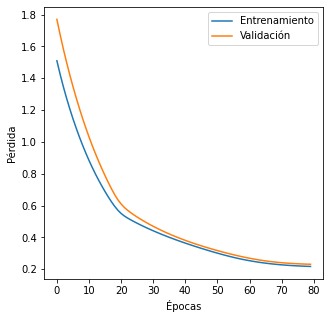

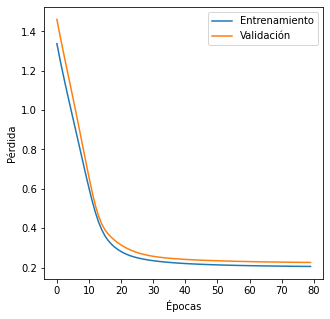

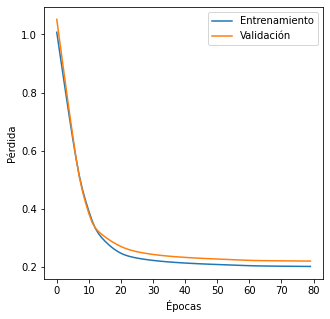

In [ ]:
for i in range(cantidad_modelos):
  plot_history(histories[i], num_epochs[0])

In [ ]:
histories[0].tail(1)

,loss,mse,val_loss,val_mse,epoch
79,0.216963,0.216963,0.230659,0.230659,79


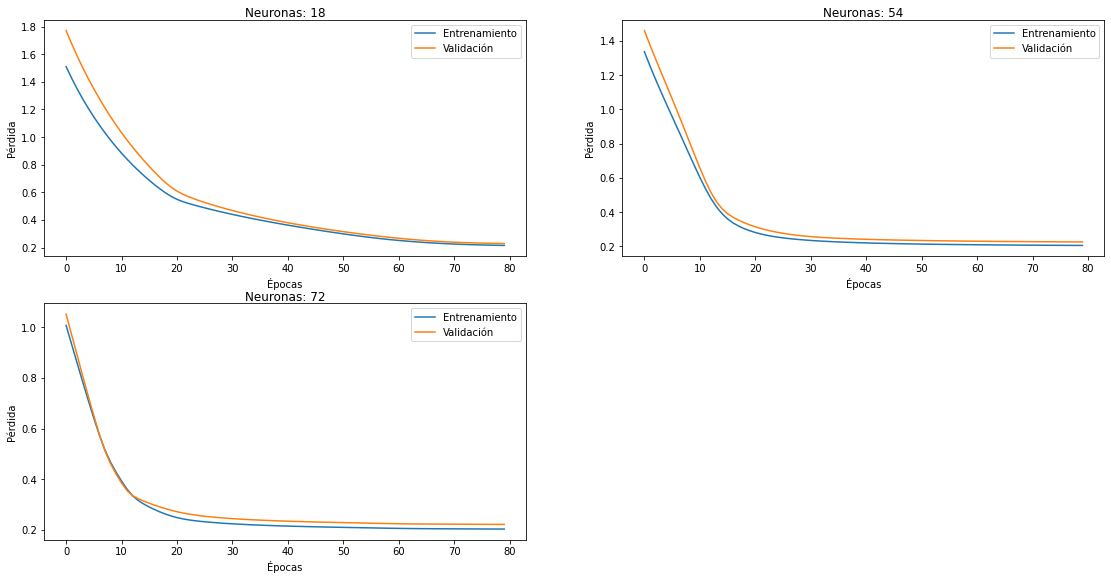

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
for h in histories:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title('Neuronas: '+ str(neurons[i]), pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))

In [ ]:
nombreModelo= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_bivariada_Smoteen_VariaNeuronas_Modelo"

#-------- GUARDA LOS MODELOS --------

In [ ]:
# serializa el modelo para JSON
for i in range(cantidad_modelos):
  model_json = models[i].to_json()
  with open(nombreModelo+str(i)+".json", "w") as json_file:
    json_file.write(model_json)
  #serializan los pesos (weights) para HDF5
  models[i].save_weights(nombreModelo+str(i)+".h5")
  # guarda el history
  histories[i].to_csv(nombreModelo+'history_'+str(i)+'.csv',  index = False, header=True)  

print("Modelos guardado en el PC")
json_file.close()

Modelos guardado en el PC


# **Recuperar los modelos**

In [ ]:
# carga el json y crea el modelo
models=[]
histories=[]

for i in range(cantidad_modelos):
  json_file = open(nombreModelo+str(i)+".json", 'r')
  loaded_model_json = json_file.read()  
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # se cargan los pesos (weights) en el nuevo modelo
  loaded_model.load_weights(nombreModelo+str(i)+".h5")
  models.append(loaded_model)
  # recupero el loss (mse) y el error (mae) de entrenamiento
  histories.append(pd.read_csv(nombreModelo+'history_'+str(i)+'.csv'))  

print("Modelos recuperados en el PC")

Modelos recuperados en el PC


#Evaluación y Predicción

In [ ]:
# make predictions
m_testPredict = []
m_testPredict_scaled = []

for i in range(cantidad_modelos):
  m1_testPredict = models[i].predict(testX_scaler)
  m1_testPredict = np.asarray(m1_testPredict).reshape(-1,1)
  m_testPredict_scaled.append(m1_testPredict)
  m1_testPredict = scalerY.inverse_transform(m1_testPredict)
  m_testPredict.append(m1_testPredict) 

In [ ]:
 #obtiene el error de cada modelo para el conjunto de datos de test
error_prediction=[]
error_prediction_scaled=[]
for i in range(cantidad_modelos):    
  error_prediction_scaled.append(testY_scaler.reshape(1,-1)[0] - m_testPredict_scaled[i][:,0])
  error_prediction.append(ytest.to_numpy().reshape(1,-1)[0] - m_testPredict[i][:,0])

In [ ]:
print('mse_train mse_val mse_test rmse_train mse_val mse_test r2_train r2_val r2_test')
for i in range(cantidad_modelos):
  trainpred= models[i].predict(trainX_scaler)  
  valpred= models[i].predict(validationX_scaler)  

  msetrain= mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  
  mseval =  mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))  
  msetest=  mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]) 

  rmsetrain= sqrt(mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  )
  rmseval=  sqrt(mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))) 
  rmsetest= sqrt(mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]))
  
  r2train= r2_score(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))
  r2val=   r2_score(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))
  r2test= r2_score(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0])

  print('{:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} '.format(msetrain, mseval, msetest, rmsetrain, rmseval,rmsetest, r2train, r2val, r2test))
  

mse_train mse_val mse_test rmse_train mse_val mse_test r2_train r2_val r2_test
   6.621    7.051    6.679    2.573    2.655    2.584    0.791    0.793    0.663 
   6.284    6.906    6.619    2.507    2.628    2.573    0.801    0.798    0.666 
   6.201    6.765    6.648    2.490    2.601    2.578    0.804    0.802    0.665 


In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams['font.size']=22
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 1

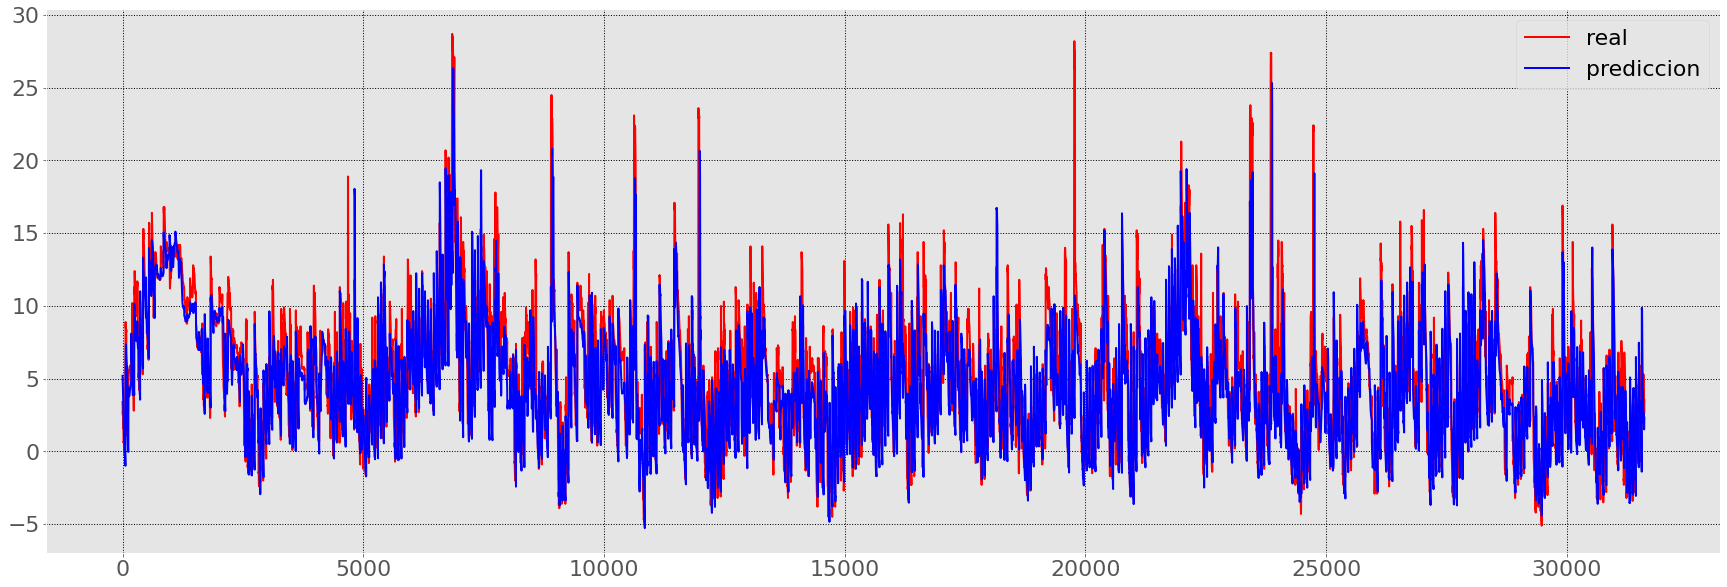

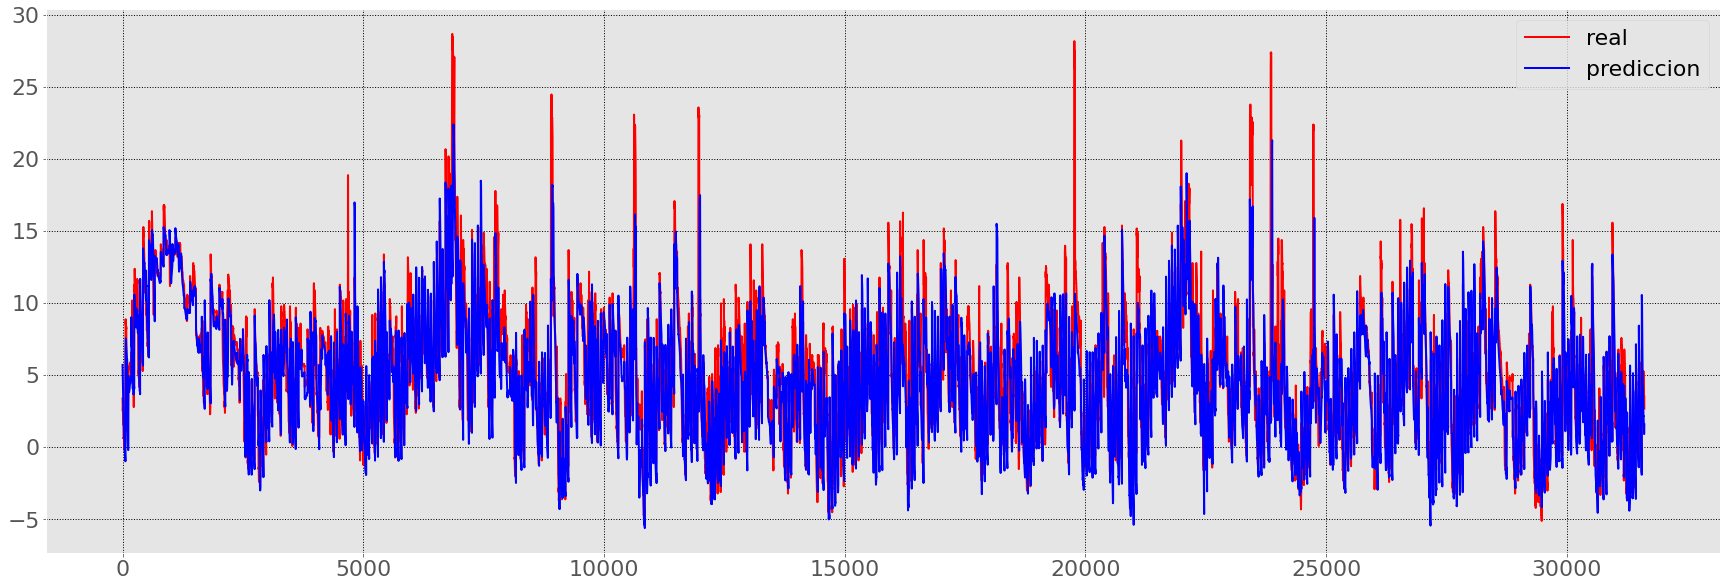

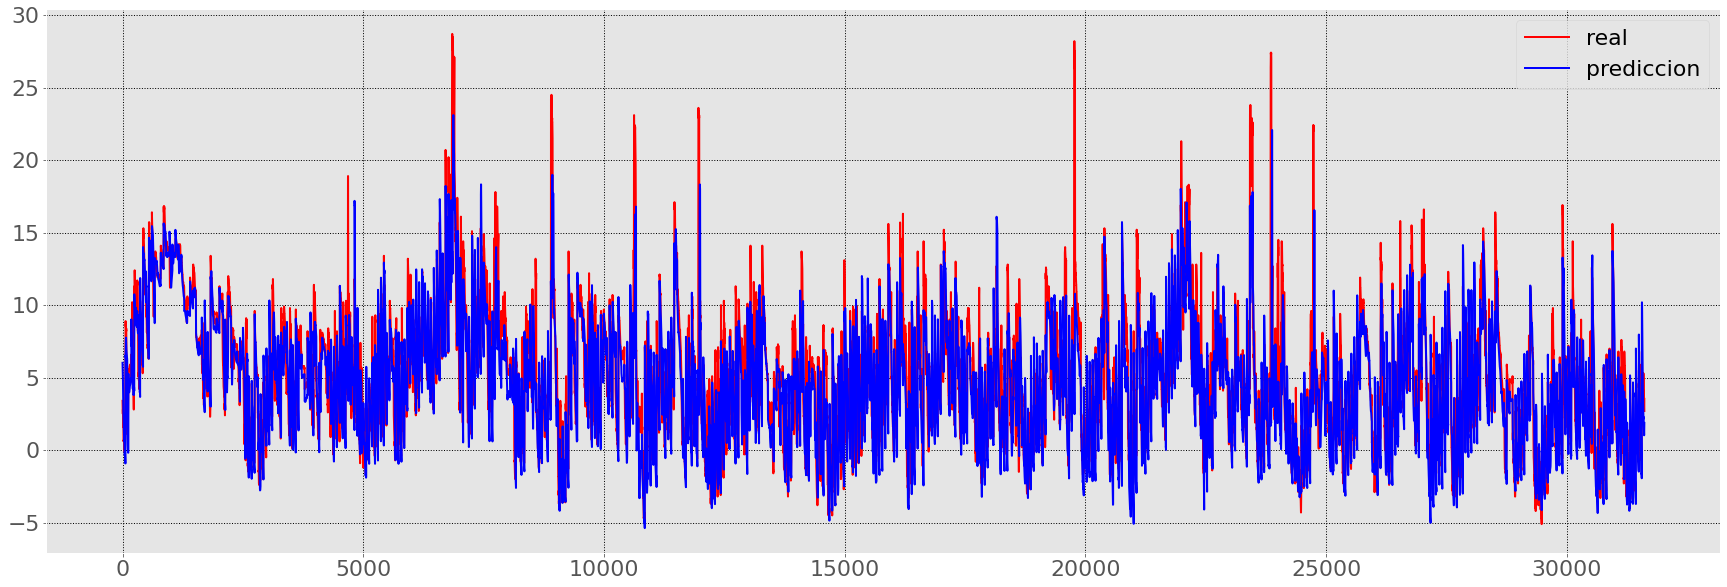

In [ ]:
for i in range(cantidad_modelos):
  plt.plot(ytest.to_numpy().reshape(1,-1)[0], color= "red", label="real")
  plt.plot(m_testPredict[i][:,0], color= "blue", label="prediccion")
  #plt.plot(error_prediction[i], color='green', label= 'error')
  plt.legend()
  plt.show()

#Helada

In [ ]:
index= ytest <= 0
ty= ytest[index]
for i in range(cantidad_modelos):
  py= m_testPredict[i][index]
  print('MSE: %.4f ' % (mean_squared_error(ty, py, squared= True)))

MSE: 2.8110 
MSE: 2.4072 
MSE: 2.3526 


In [ ]:
f_es_helada = lambda x : 0 if (x <= 0) else 1
i= 0
for i in range(len(models)):  
  binario_real = list(map(f_es_helada, ytest))
  binario_pred = list(map(f_es_helada, m_testPredict[i]))
  print("precision{:7.3f}".format(accuracy_score(binario_real, binario_pred)) )
  print(confusion_matrix(binario_real, binario_pred))
  print(classification_report(binario_real, binario_pred)) 
  i+=1

precision  0.920
[[ 2391  1369]
 [ 1149 26704]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      3760
           1       0.95      0.96      0.95     27853

    accuracy                           0.92     31613
   macro avg       0.81      0.80      0.81     31613
weighted avg       0.92      0.92      0.92     31613

precision  0.919
[[ 2818   942]
 [ 1628 26225]]
              precision    recall  f1-score   support

           0       0.63      0.75      0.69      3760
           1       0.97      0.94      0.95     27853

    accuracy                           0.92     31613
   macro avg       0.80      0.85      0.82     31613
weighted avg       0.93      0.92      0.92     31613

precision  0.919
[[ 2873   887]
 [ 1687 26166]]
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3760
           1       0.97      0.94      0.95     27853

    accuracy                          

In [ ]:
pred_paraheladasreales=[]
yreales= ty.to_numpy()
for i in range(cantidad_modelos):
  py= m_testPredict[i][index]
  ypredichos= py.reshape(-1)
  pred_paraheladasreales.append(ypredichos)


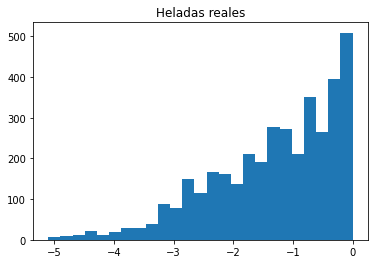

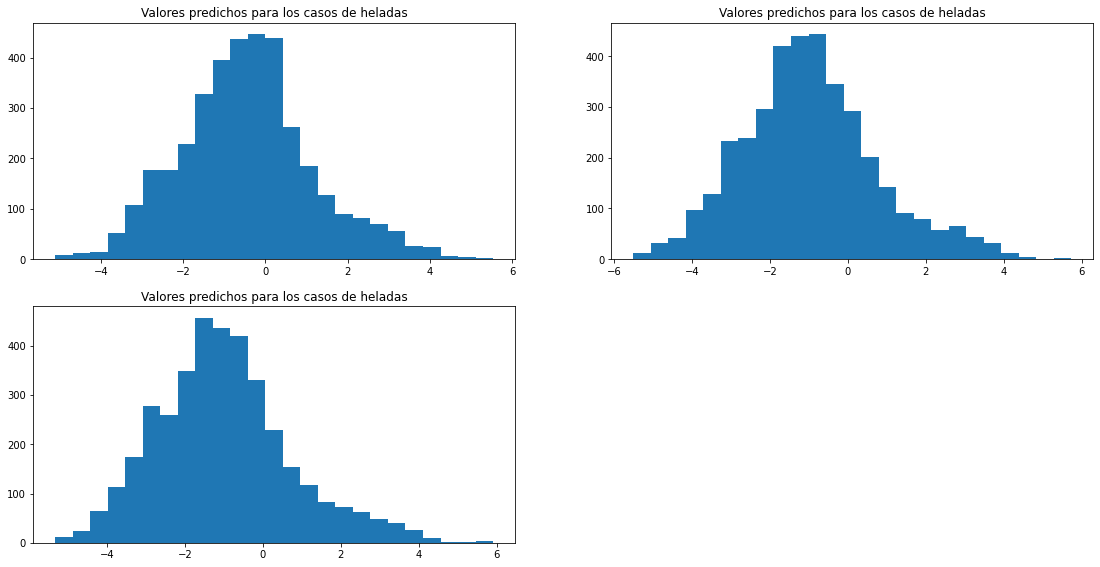

In [ ]:
plt.hist(yreales, bins=25)
plt.title('Heladas reales')
plt.show()
pyplot.figure(figsize=(19, 20))
for i in range(cantidad_modelos):
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.hist(pred_paraheladasreales[i], bins=25)
  plt.title('Valores predichos para los casos de heladas')
plt.show()


In [ ]:
diferencia= yreales - ypredichos
print(min(diferencia), max(diferencia))

-5.687242317199707 3.916497993469238


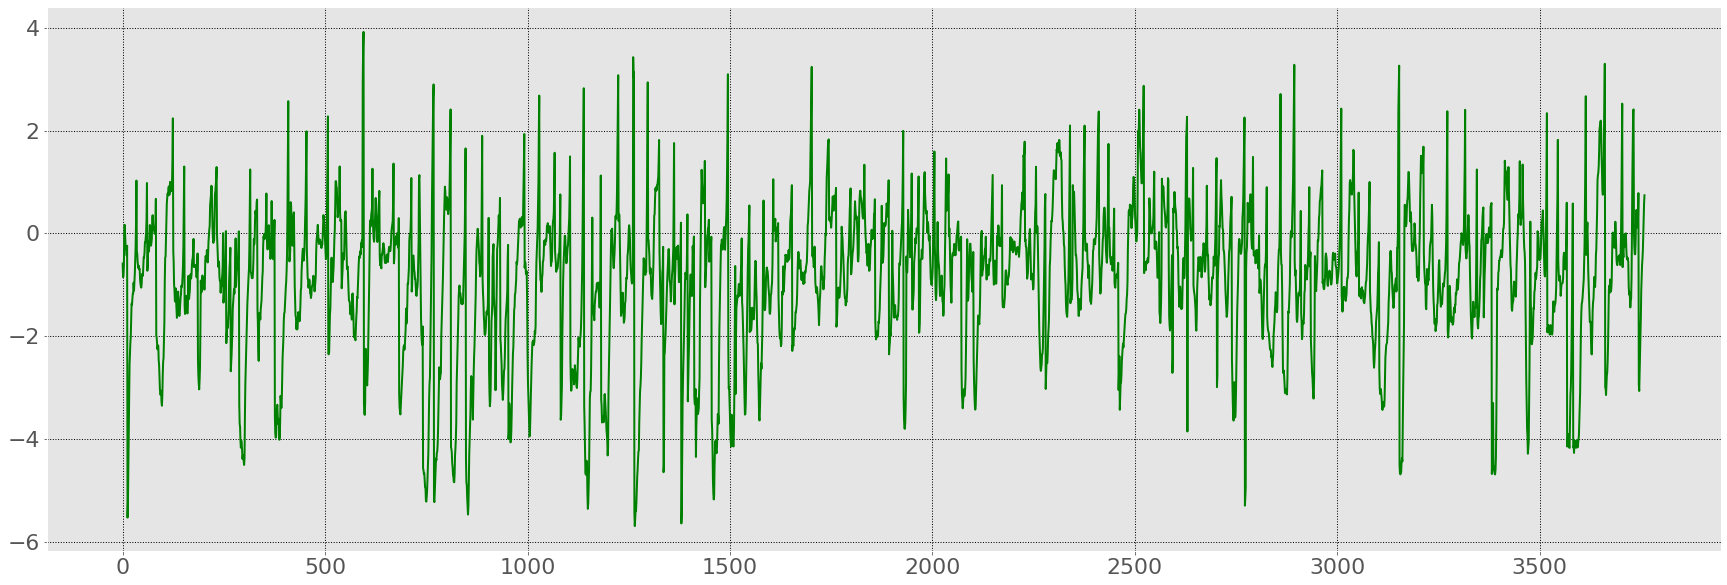

In [ ]:
 plt.plot(diferencia, color= "green", label="Error")
 plt.show()

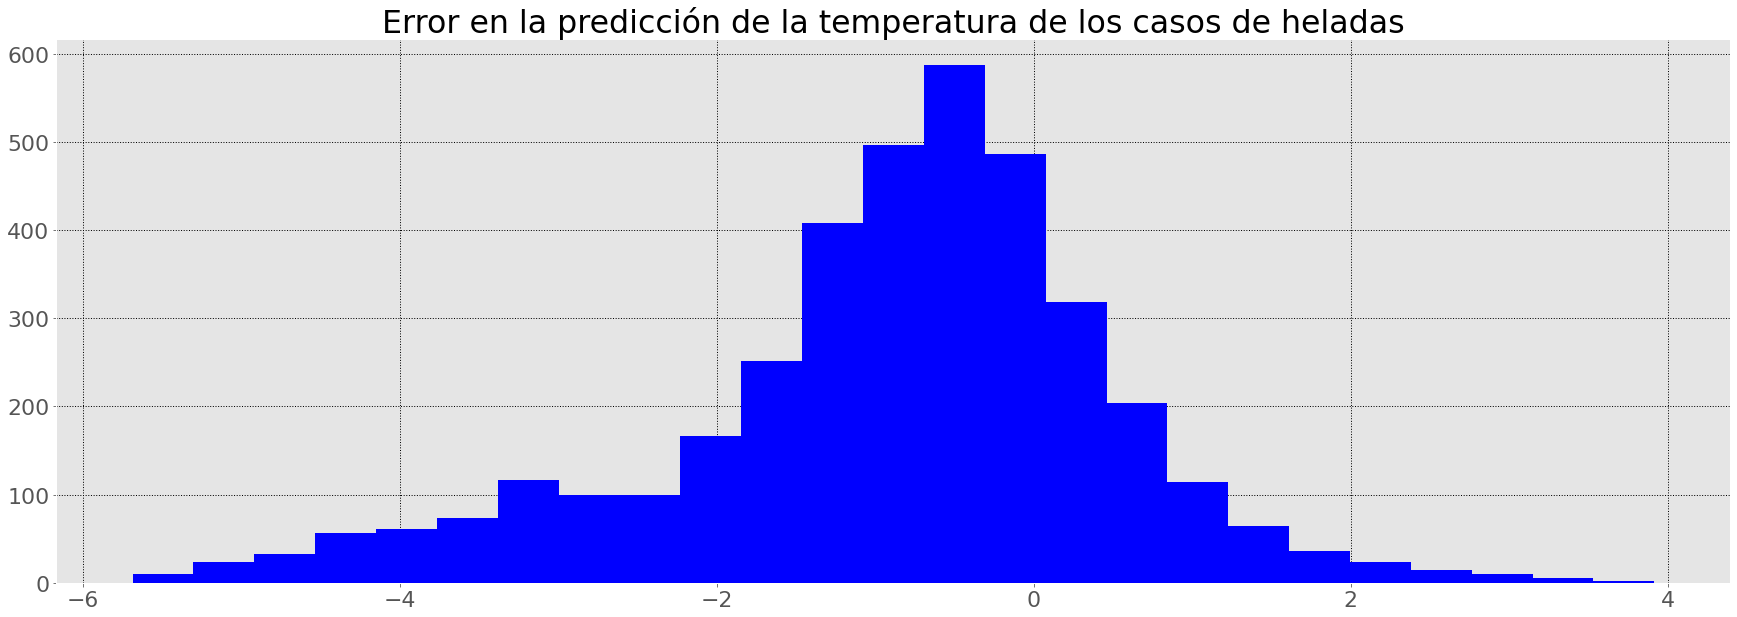

In [ ]:
plt.hist(diferencia, bins=25,color = "blue")
plt.title('Error en la predicción de la temperatura de los casos de heladas')
plt.show()

In [ ]:
predicciones_menores= yreales > ypredichos
#predicciones_mayores= yreales < ypredichos
#ocurrencias = dict((i, predicciones_menores.count(i)) for i in predicciones_menores)
print(predicciones_menores)
import collections

counter = collections.Counter(predicciones_menores)
print(counter)

[False False False ...  True  True  True]
Counter({False: 2887, True: 873})


************************

In [ ]:
nombreModelo36= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_bivariada_Smoteen_Modelo"

In [ ]:
nombreModelovarias= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_bivariada_Smoteen_VariaNeuronas_Modelo"

In [ ]:
histories=[]
histories.append(pd.read_csv(nombreModelovarias+'history_0.csv'))  
histories.append(pd.read_csv(nombreModelo36+'history_0.csv'))  
histories.append(pd.read_csv(nombreModelovarias+'history_1.csv'))  
histories.append(pd.read_csv(nombreModelovarias+'history_2.csv'))  

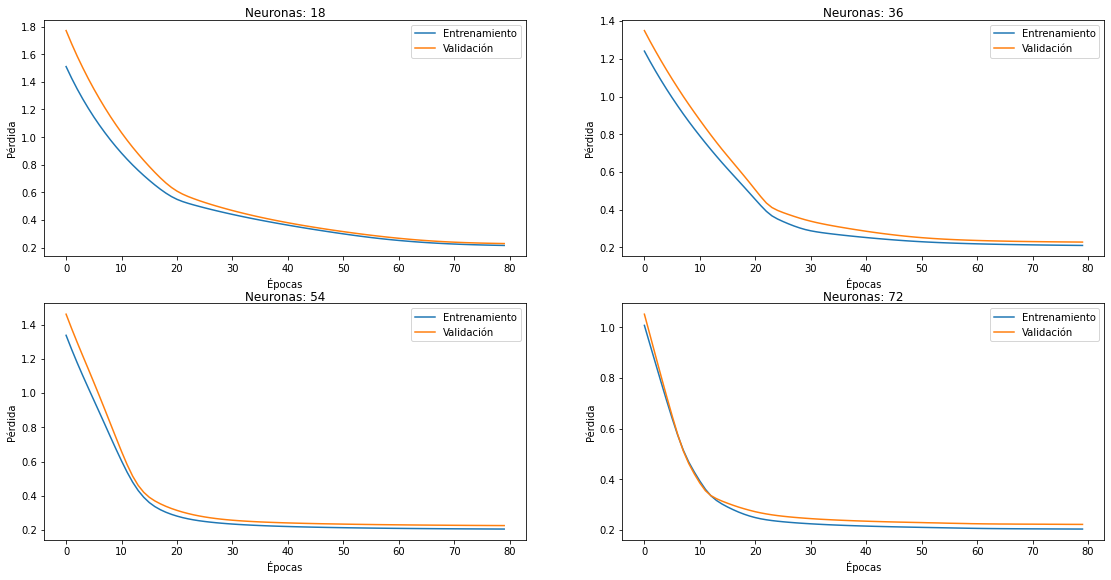

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
neurons=[18,36,54,72]
pyplot.figure(figsize=(19, 20))
i=0
for h in histories:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title('Neuronas: '+ str(neurons[i]), pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))